In [1]:
%load_ext autoreload
%autoreload 2

In [631]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import predict

from numba import njit
from scipy.spatial import cKDTree
from decode_fish.funcs.evaluation import *

import io, requests, glob

from decode_fish.funcs.merfish_eval import *
from decode_fish.funcs.exp_specific import *
from starfish import data
import pprint
import seaborn as sns

import plotly.express as px
import plotly.io as pio
pio.renderers.default='notebook'

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [580]:
out_dir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_5b/*'
files = glob.glob(out_dir)
base_str = 'bsub -gpu "num=1" -q gpu_rtx -n 3 -o logs/ofish.log -e logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/merfish_eval.py '

with open('run_slurm.sh', 'w') as f:
    for n in files:
        name = n.split('/')[-1]
        f.write(base_str + f'run_name={name}' + ' \n')

In [468]:
bench_df, code_ref, targets = get_merfish_mop(return_bench_df=True)
bench_df = get_mop_fov(bench_df, 150)
bench_df = nm_to_px(bench_df, [1.085,1.085,1.085])
bench_df['x'] += 70
bench_df['y'] += 70
bench_df = crop_df(bench_df, np.s_[:,:,500:1500,500:1500], px_size_zyx=[100., 100., 100.])
bench_df['z'] = bench_df['z']/10
len(bench_df)

17130008


8835

In [656]:
sweep_name = 'merfish_sweep_mop_5b'
# sweep_name = 'merfish_sweep_ci_15_'

df_dict = {}
# df_dict['istdeco'] = istdeco_df
df_dict['bench'] = bench_df

for f in glob.glob(f'../data/results/MERFISH/{sweep_name}*'):
#     if 'per_channel' in f:
#     print(f)
    dec_df = pd.read_csv(f)
    dec_df = sel_int_ch(dec_df, code_ref)
    dec_df['zm'] = dec_df['z']%100
    dec_df['int_sig_tot'] = np.sqrt(dec_df['int_sig_0']**2+dec_df['int_sig_1']**2+dec_df['int_sig_2']**2+dec_df['int_sig_3']**2)
    dec_df['bla'] = 1/10*dec_df['int_sig_tot'] + dec_df['comb_sig']
    df_dict['dec'+f.split(sweep_name)[-1].split('.csv')[0]] = dec_df

(24933, 4)
(15409, 4)
(15891, 4)
(15020, 4)
(25344, 4)
(25714, 4)
(264, 4)
(30249, 4)
(12701, 4)
(26643, 4)
(2811, 4)
(24969, 4)
(3104, 4)


IndexError: arrays used as indices must be of integer (or boolean) type

In [666]:
res_df = df_dict['dec_l1_reg:0.0003xpsf_vol:True']

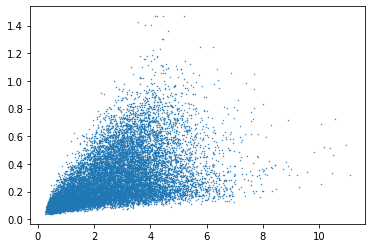

In [653]:
plt.scatter(res_df['int_sig_tot'], res_df['comb_sig'], s=0.2)

In [667]:
res_single = remove_doublets(res_df)

In [668]:
res_sub_s = res_single.nsmallest(10000, 'comb_sig')
res_sub_m = res_df.nsmallest(10000, 'comb_sig')

In [615]:
# res_single = remove_doublets(res_sub_m)

In [671]:
_,matches,shift = matching(bench_df, res_sub_m, tolerance=500, print_res=True, allow_multiple_matches=False)

Recall: 0.647
Precision: 0.572
Jaccard: 43.581
RMSE_vol: 108.147
Eff_3d: 21.853
FN: 3118.0 FP: 4283.0
Num. matches: 5717.000
Shift: 3.32,2.72,63.33


In [672]:
_,matches,shift = matching(bench_df, res_sub_s, tolerance=500, print_res=True, allow_multiple_matches=False)

Recall: 0.661
Precision: 0.584
Jaccard: 44.918
RMSE_vol: 108.077
Eff_3d: 22.837
FN: 2997.0 FP: 4162.0
Num. matches: 5838.000
Shift: 3.65,2.71,60.38


In [623]:
_,matches,shift = matching(bench_df, res_sub_m, tolerance=500, print_res=True, allow_multiple_matches=True)

Recall: 0.852
Precision: 0.752
Jaccard: 66.534
RMSE_vol: 109.307
Eff_3d: 35.914
FN: 1310.0 FP: 2475.0
Num. matches: 7525.000
Shift: 3.12,2.12,61.47


8501 8835


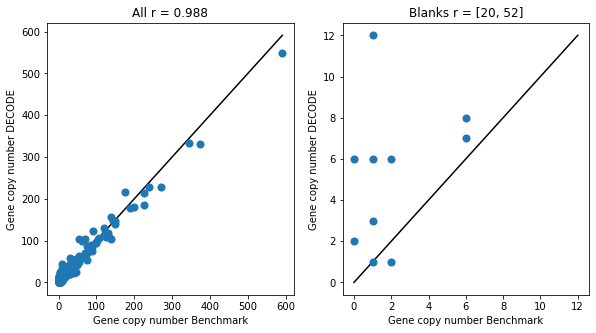

In [630]:
plot_gene_panels(res_sub_m.nsmallest(8835, 'comb_sig'), bench_df, targets)

Text(0.5, 0, '# localizations matched')

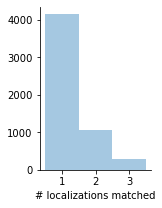

In [624]:
plt.figure(figsize=(2,3))
sns.distplot(matches.groupby('loc_idx_tar')['loc_idx_tar'].count(), bins=[0.5,1.5,2.5,3.5],kde=False)
sns.despine()
plt.xlabel('# localizations matched')

In [673]:
fns = bench_df.loc[~bench_df['loc_idx'].isin(matches['loc_idx_tar'])]
tps = bench_df.loc[bench_df['loc_idx'].isin(matches['loc_idx_tar'])]
fps = res_sub_m.loc[~res_sub_m['loc_idx'].isin(matches['loc_idx_pred'])]
print(tps['gene'].str.contains('Blank').sum()/len(tps)*100)
print(fns['gene'].str.contains('Blank').sum()/len(fns)*100)
print(fps['gene'].str.contains('Blank').sum()/len(fps)*100)

0.051387461459403906
0.5672339005672339
0.5407743889249406


In [674]:
gene_counts = DF(data=None, index=targets)
gene_counts['dec'] = res_sub_s.groupby('gene')['gene'].count()
gene_counts['ist'] = bench_df.groupby('gene')['gene'].count()
gene_counts['tps'] = tps.groupby('gene')['gene'].count()
gene_counts['fps'] = fps.groupby('gene')['gene'].count()
gene_counts['fns'] = fns.groupby('gene')['gene'].count()
gene_counts = gene_counts.fillna(0)

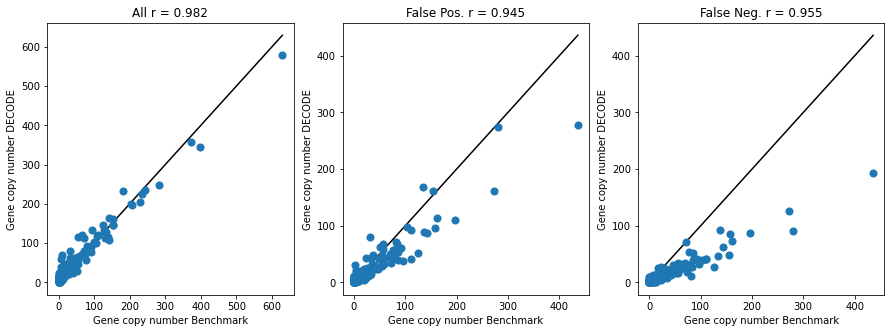

In [675]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plot_gene_numbers(gene_counts['ist'].values, gene_counts['dec'].values, 'All', log=False)
plt.subplot(132)
plot_gene_numbers(gene_counts['tps'].values, gene_counts['fps'].values, 'False Pos.', log=False)
plt.subplot(133)
plot_gene_numbers(gene_counts['tps'].values, gene_counts['fns'].values, 'False Neg.', log=False)

Text(0.5, 1.0, 'Corr. 0.954')

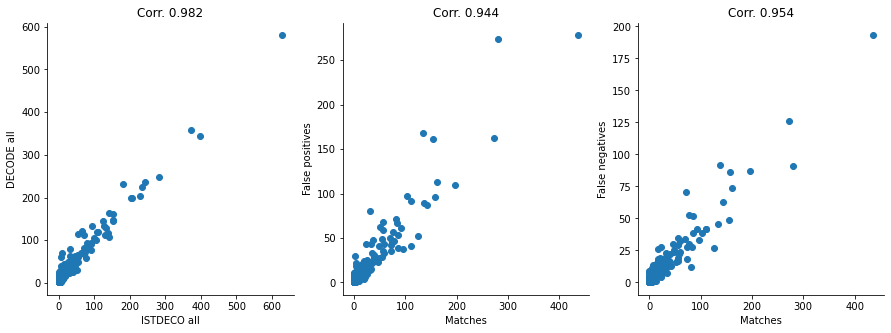

In [676]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(gene_counts['ist'].values, gene_counts['dec'].values)
plt.plot([0,0],[len(gene_counts['ist'].values),len(gene_counts['dec'].values)])
sns.despine()
plt.xlabel('ISTDECO all')
plt.ylabel('DECODE all')
plt.title('Corr. ' + str(np.corrcoef(gene_counts['ist'].values, gene_counts['dec'].values)[0,1])[:5])
plt.subplot(132)
plt.scatter(gene_counts['tps'].values, gene_counts['fps'].values)
sns.despine()
plt.xlabel('Matches')
plt.ylabel('False positives')
plt.title('Corr. ' + str(np.corrcoef(gene_counts['tps'].values, gene_counts['fps'].values)[0,1])[:5])
plt.subplot(133)
plt.scatter(gene_counts['tps'].values, gene_counts['fns'].values)
sns.despine()
plt.xlabel('Matches')
plt.ylabel('False negatives')
plt.title('Corr. ' + str(np.corrcoef(gene_counts['tps'].values, gene_counts['fns'].values)[0,1])[:5])


In [660]:
par_dict = {}

for i,k in enumerate(df_dict):
    if 'dec_' in k:
        if len(df_dict[k]) > 0:
            par_dict[k] = [df_dict[k], 'comb_sig', True]
#             par_dict[k+'_s'] = [remove_doublets(df_dict[k]), 'comb_sig', True]

roc_dict = {}
for k in par_dict:
    x, y = make_roc(*par_dict[k], n_max=25000)
    roc_dict[k] = [x, y]

In [661]:
df = pd.DataFrame(columns=roc_dict.keys())
df['x'] = roc_dict[df.keys()[0]][0]
for k in roc_dict.keys():
    df[k] = roc_dict[k][1]

In [662]:
fig = px.line(df, x="x", y=list(roc_dict.keys()), range_y=[0,100], range_x=[0,15000], labels={"x": "Number genes","value":'Number blanks'})
fig.show()

In [644]:
fig = px.line(df, x="x", y=list(roc_dict.keys()), range_y=[0,100], range_x=[0,15000], labels={"x": "Number genes","value":'Number blanks'})
fig.show()

In [569]:
res_df = df_dict['dec_enabled:Truexint_inf:per_channelxchannel_shifts:Truexchannel_facs:Truexn_foci_avg:1xseed:2']
int_m = [f'int_{i}' for i in range(4)]
int_s = [f'int_sig_{i}' for i in range(4)]
res_df['int_tot'] = res_df.loc[:,int_m].values.sum(-1)
res_df['int_sig_tot'] = res_df.loc[:,int_s].values.sum(-1)


metrics = ['comb_sig','int_tot','int_sig_tot', 'prob','zm']
bins = [np.linspace(0,1.5,31), np.linspace(0,50,31), np.linspace(0,20,31), np.linspace(0.4,1,31), np.linspace(0,100.,31)]
plt.figure(figsize=(20,5))
for i in range(len(metrics)):
    plt.subplot(1,len(metrics),i+1)
    _=plt.hist(res_df[~res_df['gene'].str.contains('Blank')][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='gene matches')
    _=plt.hist(res_df[res_df['gene'].str.contains('Blank')][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='blank matches')
    plt.title(metrics[i])

KeyError: 'dec_enabled:Truexint_inf:per_channelxchannel_shifts:Truexchannel_facs:Truexn_foci_avg:1xseed:2'

In [299]:
res_df = df_dict['dec_enabled:Truexint_inf:per_channelxchannel_shifts:Truexchannel_facs:Truexn_foci_avg:1xseed:2'].nsmallest(10000, 'comb_sig')

In [290]:
code_cols = [plt.get_cmap('gist_ncar')(x) for x in np.linspace(0.,1.,140)]

In [291]:
import mpld3
from mpld3 import plugins

In [663]:
res_sub = df_dict['dec_psf_noise:0.0xrate_fac:3.0'].nsmallest(17000, 'comb_sig')
# res_sub = df_dict['dec_min_int_sig:0.0xint_fac:0.1'].nsmallest(15000, 'code_err')
ist_sub = istdeco_df.nlargest(15000, 'quality')
bench_sub = bench_df.nlargest(13800, 'total_magnitude')

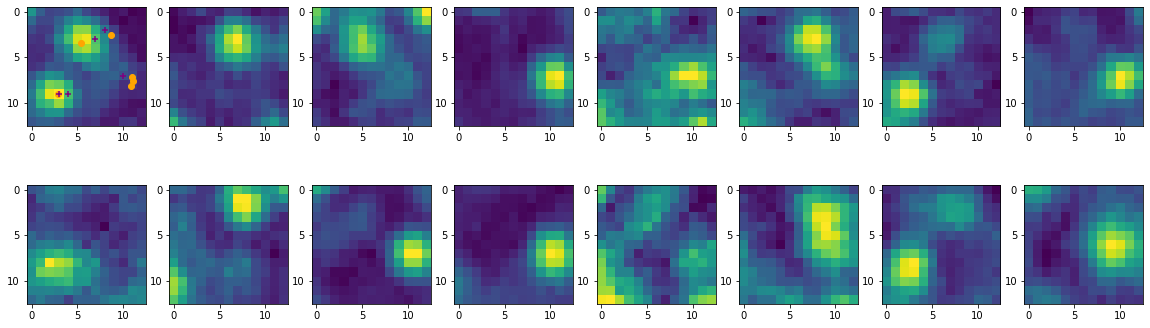

In [664]:
vol, crop = extract_roi(img_stack[None], torch.IntTensor([514,740,0]), 6, 8)

res_crop = crop_df(nm_to_px(res_sub), crop)
ist_crop = crop_df(nm_to_px(ist_sub), crop)

plt.figure(figsize=(20,6))
for i in range(16):
    plt.subplot(2,8,i+1)
    plt.imshow(vol[0,i])
    
    if not i:
        plt.scatter(res_crop['x'],res_crop['y'],color='orange')
        plt.scatter(ist_crop['x'],ist_crop['y'],color='purple', marker='+')

In [395]:
img_stack = read_MOp_tiff(base_path+'/datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_images150.tif')[:,:,500:1500,500:1500]

In [367]:
from decode_fish.funcs.dataset import GaussianSmoothing
filt = GaussianSmoothing(11, device='cpu')
img_filt = filt(img_stack)
img_stack -= img_filt

In [389]:
res_df = df_dict['dec_enabled:Truexint_inf:per_channelxchannel_shifts:Truexchannel_facs:Truexn_foci_avg:1xseed:2'].nsmallest(10000, 'comb_sig')

In [390]:
def extract_roi(beads: torch.Tensor, coordinates, size_xy=5, size_z=10):
    res = []
    
    x, y, z = coordinates
    crop = np.s_[:,z-1:z+2, int(y-size_xy): int(y+size_xy+1), int(x-size_xy): int(x+size_xy+1)]
    single_bead = beads[crop]
        
    return single_bead, crop

In [391]:
z_vols = [[] for _ in range(20)]

In [392]:
for i in tqdm(range(len(res_df))):
    b_loc = nm_to_px(res_df.iloc[i])
    vol, crop = extract_roi(img_stack, torch.IntTensor(np.array(b_loc.loc[['x','y','z']].values, dtype='float32')), 6, 8)
    if vol.shape == torch.Size([22, 3, 13, 13]):
        volm = cpu(vol[code_ref[b_loc['code_inds']].nonzero()[0]])
        ints = b_loc[['int_0','int_1','int_2','int_3']].values.astype('float32')
        volm /= ints[:,None,None,None]
        z_vols[int(b_loc['zm']/5)].append(volm)

100%|█████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 850.10it/s]


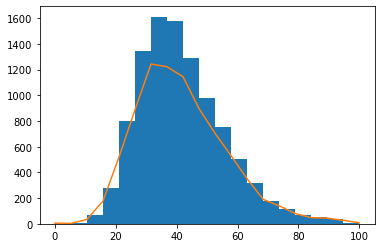

In [393]:
plt.hist(res_df['zm'], bins=np.linspace(0,100,20))
plt.plot(np.linspace(0,100,20), [len(z) for z in z_vols])

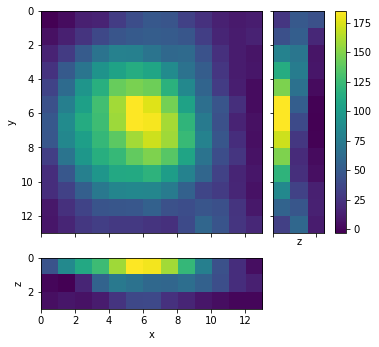

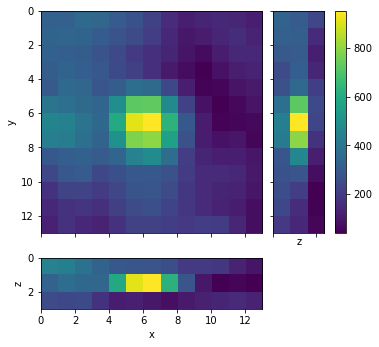

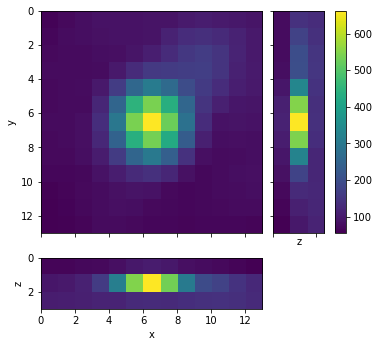

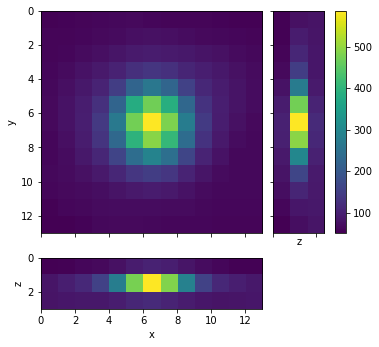

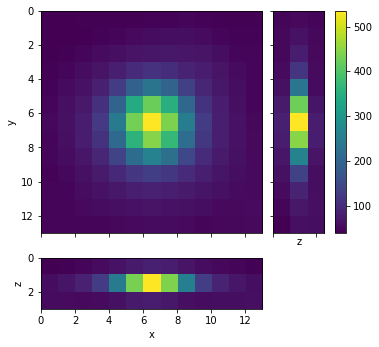

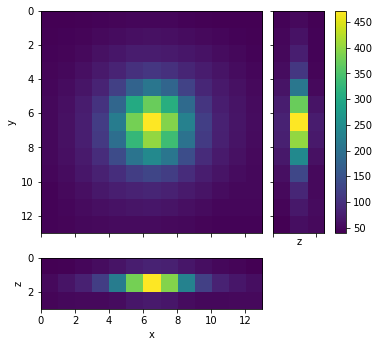

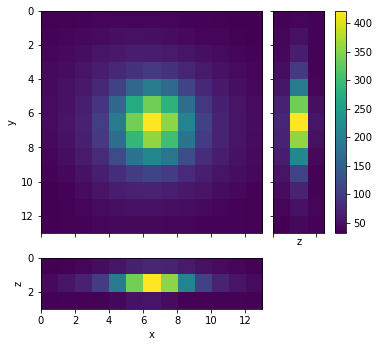

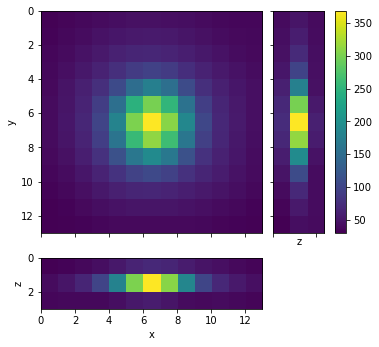

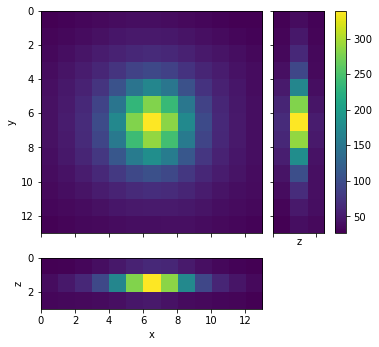

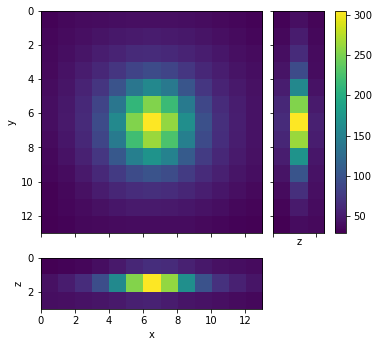

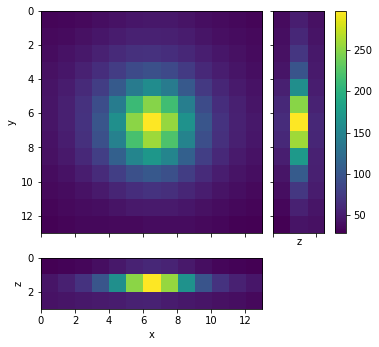

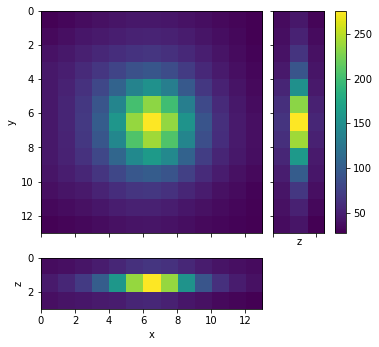

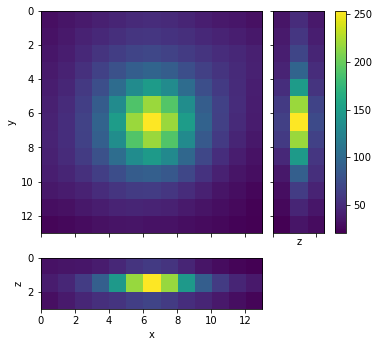

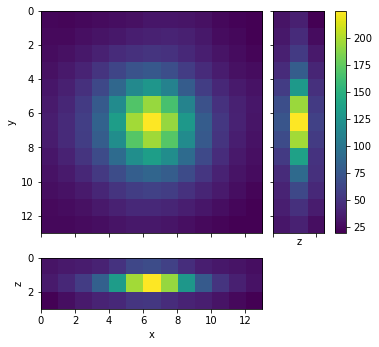

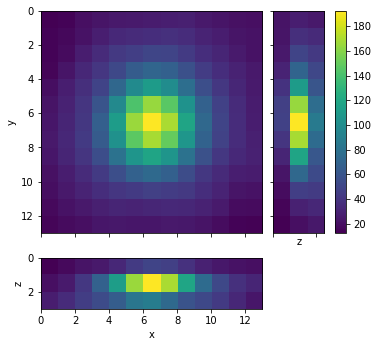

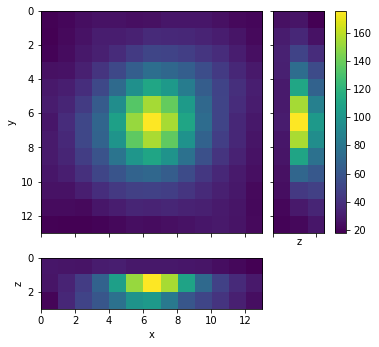

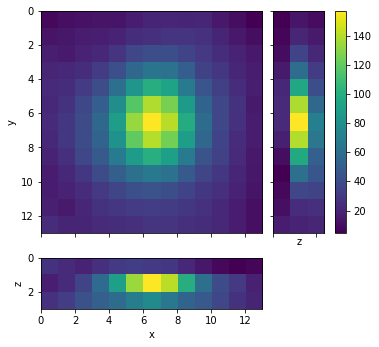

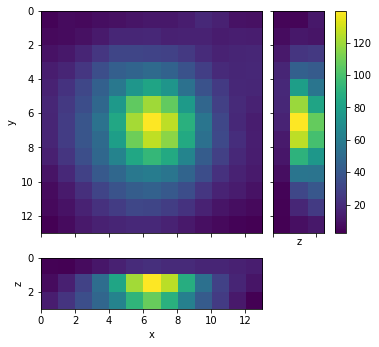

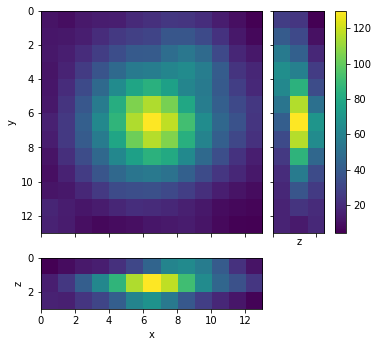

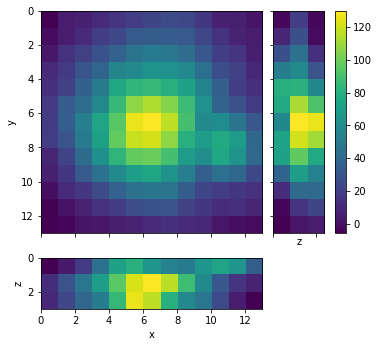

In [579]:
for i in range(len(z_vols)):
    mvol = np.stack(z_vols[i]).mean(0).mean(0)
    plot_3d_projections(mvol, size=4)
    plt.show()

21392


(600.0, 750.0)

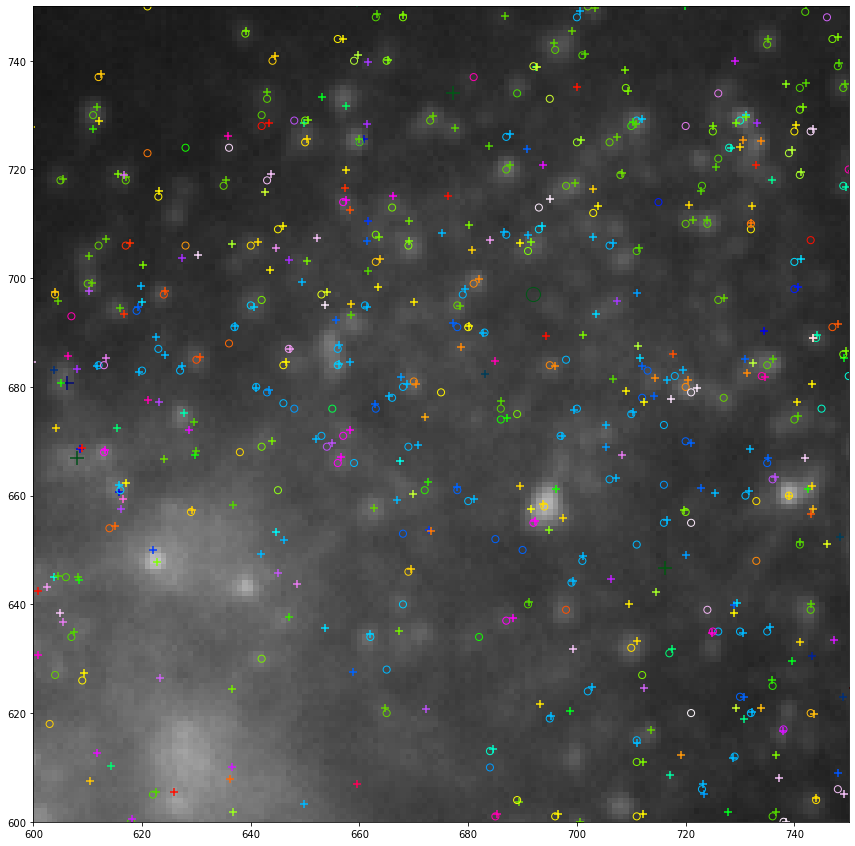

In [63]:
ind = 0
img = load_tiff_image(image_paths[ind])
preds_px = nm_to_px(res_single)#[res_df['gene']!='MALAT1']
bench_px = nm_to_px(ist_sub)#[bench_df['gene']!='MALAT1']
print(len(preds_px))
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(img[0,0], cmap='gray')

for i in range(len(targets)):
    
    preds_sub = preds_px[preds_px['code_inds'] == i]
    bench_sub = bench_px[bench_px['code_inds'] == i]
    
    size = 200. if 'Blank' in targets[i] else 50.

    ax.scatter(bench_sub['x'],bench_sub['y'], color=code_cols[i], s=size, marker='o', facecolor='none')
    ax.scatter(preds_sub['x'],preds_sub['y'], color=code_cols[i], s=size, marker='+')

ax.set_xlim(600,750)
ax.set_ylim(600,750)

# plugins.connect(fig, plugins.MousePosition(fontsize=14))
# mpld3.display()

In [409]:
def extract_roi(beads: torch.Tensor, coordinates, size_xy=5, size_z=10):
    res = []
    
    x, y, z = coordinates
    crop = np.s_[:,int(z):int(z+1), int(y-size_xy): int(y+size_xy+1), int(x-size_xy): int(x+size_xy+1)]
    single_bead = beads[crop]
        
    return single_bead, crop

# Analyze blanks

26


,loc_idx,frame_idx,code_inds,x,y,z,prob,x_sig,y_sig,z_sig,...,int_1,int_2,int_3,int_sig_0,int_sig_1,int_sig_2,int_sig_3,zm,int_tot,int_sig_tot
28421,28421,0,243,383.26723,68.88303,2.376363,0.658758,17.744606,23.340118,8.481233,...,5.209935,6.694495,8.023641,1.996939,1.568243,3.390814,3.319344,37.63626,26.435554,10.275341


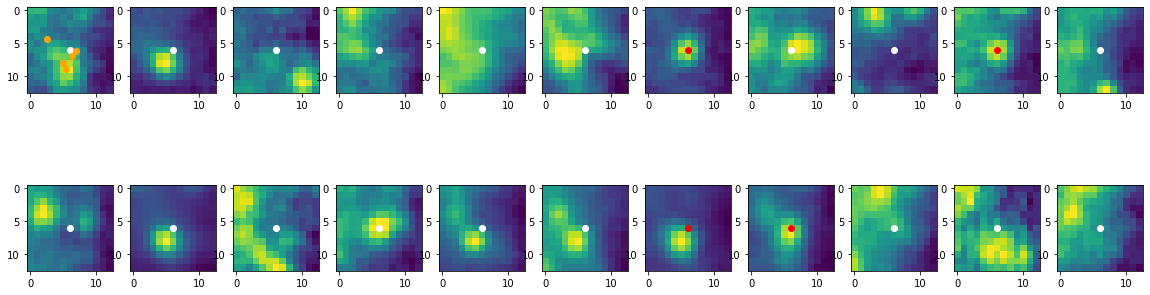

In [422]:
# Random predictions 
res_sub = res_df.nsmallest(20000, 'comb_sig')
# Random blank 
sub = res_sub[res_sub['gene'].str.contains('Blank')]

ind = np.random.randint(0, len(sub))
print(ind)

b_loc = nm_to_px(sub.iloc[ind])
display(DF(b_loc).T)
vol, crop = extract_roi(img_stack, torch.IntTensor(np.array(b_loc.loc[['x','y','z']].values, dtype='float32')), 6, 8)

res_crop = crop_df(nm_to_px(res_sub), crop)
bench_crop = crop_df(nm_to_px(bench_df), crop)

plt.figure(figsize=(20,6))
for i in range(22):
    plt.subplot(2,11,i+1)
    plt.imshow(vol[i,0])
    color = 'red' if code_ref[list(targets).index(b_loc['gene'])][i] else 'white'
    plt.scatter([6],[6], color=color)
    
#     plt.title(str(np.round(b_loc[f'int_{i}'], 3)) + ' +- ' + str(np.round(b_loc[f'int_sig_{i}'], 3)))
    
    if not i:
        plt.scatter(res_crop['x'],res_crop['y'],color='orange')
        plt.scatter(bench_crop['x'],bench_crop['y'],color='purple', marker='+')

In [677]:
fn_inds = fns['loc_idx'].values

In [678]:
len(res_df)

15020

In [679]:
res_sub = res_df.nsmallest(10000, 'comb_sig')

,loc_idx,x,y,z,gene,frame_idx,code_inds
5894569,5894569,90.023502,729.022581,2.304147,Pdgfc,0,152


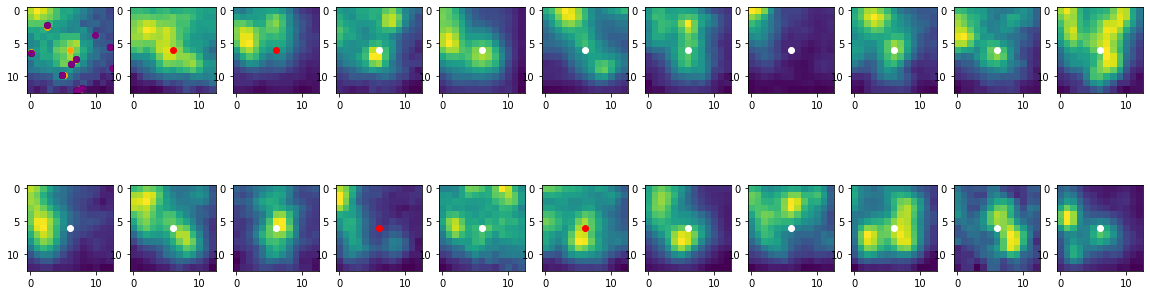

In [681]:
ind = np.random.randint(0, len(fn_inds))
ind = fn_inds[ind]

b_loc = nm_to_px(bench_df[bench_df['loc_idx'] == ind], px_size_zyx=[120.0, 100.0, 100.0]).iloc[0]

display(DF(b_loc).T)
vol, crop = extract_roi(img_stack, torch.IntTensor(np.array(b_loc.loc[['x','y','z']].values, dtype='float32')), 6, 8)

cropb = crop_df(nm_to_px(bench_df, px_size_zyx=[120.0, 100.0, 100.0]), crop)
cropr = crop_df(nm_to_px(res_sub), crop)
cropf = crop_df(nm_to_px(res_df), crop)

plt.figure(figsize=(20,6))
for i in range(22):
    plt.subplot(2,11,i+1)
    plt.imshow(vol[i,0])
    color = 'red' if code_ref[list(targets).index(b_loc['gene'])][i] else 'white'
    plt.scatter([6],[6], color=color)
    
    if not i:
        plt.scatter(cropb['x'],cropb['y'],color='orange')
        plt.scatter(cropr['x'],cropr['y'],color='black')
        plt.scatter(cropf['x'],cropf['y'],color='purple')

In [545]:
cropb

,loc_idx,x,y,z,gene,frame_idx,code_inds
5911774,5911774,6.497235,6.030876,0.760369,Olfm3,0,144


In [546]:
cropf[['x','y','z','comb_sig','gene']]

,x,y,z,comb_sig,gene


In [547]:
cropr[['x','y','z','comb_sig','gene']]

,x,y,z,comb_sig,gene
